In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import plotly.io as pio
import math

rcParams = {
    'xtick.labelsize': 12,
    'axes.titlesize': 28,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 2
}
sns.set_context("paper", font_scale=2, rc=rcParams)

In [6]:
# Get the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=5)

method_colors = {
    'THOI - GC': colorblind_palette[0],
    'HOI - GC': colorblind_palette[2],
    'GCMI - GC': colorblind_palette[4],
    'NPEET - KSG': colorblind_palette[1],
    'JIDT - KSG': colorblind_palette[3]
}

In [7]:
def estimated_computation_time(time_order_5, order):
    # assumes a system of 30 variables and 100000 samples
    nplet_time = time_order_5 / math.comb(30,5)
    return math.comb(30, order) * nplet_time


def get_quituplet_time_from_df(df, library, estimator):
    return df[(df.library == library) & (df.estimator == estimator) & (df['T'] == 1000) & (df.order == 5)]['time'].values[0]


def plot_estimated_computation_times(df, ax):

    quintuplet_times = {
        ('HOI','GC'): get_quituplet_time_from_df(df, 'HOI', 'GC'),
        ('GCMI', 'GC'): get_quituplet_time_from_df(df, 'GCMI', 'GC'),
        ('NPEET', 'KSG'): get_quituplet_time_from_df(df, 'NPEET', 'KSG'),
        ('JIDT', 'KSG'): get_quituplet_time_from_df(df, 'JIDT', 'KSG')
    }

    dfs = []
    for (library, estimator), tuple_t in quintuplet_times.items():
        df = pd.DataFrame({
            'time': [estimated_computation_time(tuple_t,k) for k in range(3,31)],
            'order': list(range(3,31))
        })
        df['library'] = library
        df['estimator'] = estimator
        df['T'] = 1000
        df['N'] = 30
        dfs.append(df)


    # Combine all dataframes into one
    df = pd.concat(dfs, ignore_index=True)
    df['library-estimator'] = df['library'] + ' - ' + df['estimator']
    df['time'] = df['time']


    # Create a line plot using Seaborn
    ax = sns.lineplot(
        data=df, x="order", y="time",
        hue="library-estimator", style='library-estimator',
        markers=True, dashes=False, ax=ax,
        palette=method_colors
    )

    ax.set_xlabel('order or interactions')
    ax.set_ylabel('')
    ax.legend(title='Method')
    ax.grid(True)

    for k in quintuplet_times.keys():
        print(k)
        library, estimator = k
        df_lib = df[(df.library == library) & (df.estimator == estimator)]
        print('time order 15:', math.floor(df_lib[df_lib.order == 15]['time'].values[0]), 'days')
        print('time all orders:', math.floor(df_lib['time'].sum()))

('HOI', 'GC')
time order 15: 32 days
time all orders: 221
('GCMI', 'GC')
time order 15: 208 days
time all orders: 1445
('NPEET', 'KSG')
time order 15: 904 days
time all orders: 6258
('JIDT', 'KSG')
time order 15: 895 days
time all orders: 6201


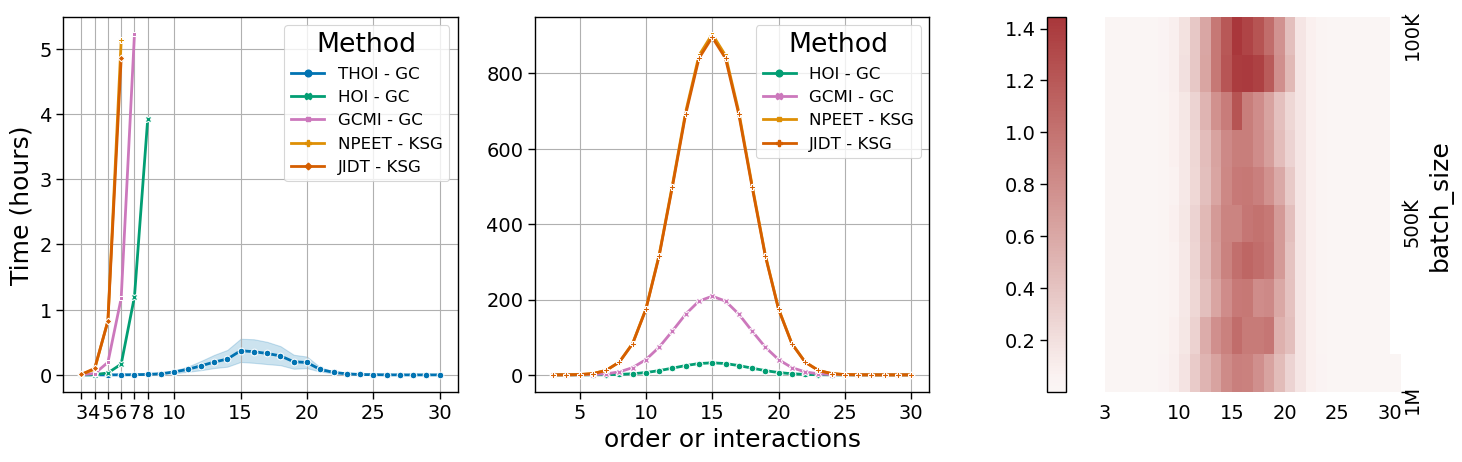

times for THOI


count    28.000000
mean      2.855683
std       3.851835
min       0.000027
25%       0.008769
50%       0.529999
75%       5.337499
max      10.783450
dtype: float64

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=False)


# Define the file paths
file_paths = [
    "library-thoi_estimator-gc.tsv",
    "library-hoi_estimator-gc.tsv",
    "library-gcmi_estimator-gc.tsv",
    "library-npeet_estimator-ksg.tsv",
    "library-jdit_estimator-ksg.tsv"
]

# Read each file into a DataFrame and assign a 'Method' column
dataframes = []
for path in file_paths:
    df = pd.read_csv(os.path.join('../benchmarking/results/times/',path), sep="\t")
    dataframes.append(df)

# Combine all dataframes into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['library-estimator'] = combined_df['library'] + ' - ' + combined_df['estimator']
combined_df['time'] = combined_df['time'] / 60 / 60

#########################################

ax = axes[0]

sns.lineplot(
    data=combined_df, x="order", y="time",
    hue="library-estimator", style='library-estimator',
    markers=True, dashes=False, ax=ax,
    palette=method_colors
)
ax.set_xticks([3,4,5,6,7,8,10,15,20,25,30])

ax.set_xlabel('')
ax.set_ylabel('Time (hours)')
ax.legend(title='Method')
ax.grid(True)


#############################################

ax = axes[1]

plot_estimated_computation_times(combined_df, ax)

#########################################

ax = axes[2]

df_thoii = combined_df[(combined_df.library == 'THOI') & (combined_df.N == 30)]

# Pivot the data to get a matrix form suitable for heatmap plotting
pivot_table = df_thoii.pivot(columns='order', index='batch_size', values="time")

# Create the heatmap
ax = sns.heatmap(
    pivot_table, cmap="vlag", center=0,
    annot=False, cbar=False, ax=ax,
)

ax.tick_params(axis='x', rotation=90)
ax.tick_params(left=False, bottom=False)

# Create the colorbar and set it to the left
cbar = ax.figure.colorbar(ax.collections[0], ax=ax, location='left')

# Move the y-axis labels to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_xlabel('')
#ax.tick_params(axis='y', length=0)

ax.set_yticks([0,5,10])
ax.set_xticks([0,7,12,17,22,27])
ax.set_yticklabels(['100K', '500K', '1M'], rotation=90, ha='center')
ax.set_xticklabels([3,10,15,20,25,30], rotation=0)


plt.tight_layout()
fig.savefig('./figures/times/benchmarking.pdf', format='pdf')
plt.show()

print('times for THOI')
pivot_table.sum(axis=0).describe()

In [10]:
# Read the data
df = pd.read_csv('../benchmarking/results/times/library-thoi_estimator-gc.tsv', sep='\t')
df = df[['N', 'order', 'batch_size', 'time']]

df = df[(df.N == 30) & (df.order == 15)]

# Create the list of dimensions with correct ranges
dimensions = []
for column in df.columns:
    if column != 'time':
        dimensions.append(
            dict(
                range=[df[column].min(), df[column].max()],
                label=column, values=df[column]
            )
        )

# Create the parallel coordinate plot
fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['time'],
            colorscale='Solar',
            showscale=True,
            cmin=df['time'].min(),
            cmax=df['time'].max()
        ),
        dimensions=dimensions
    )
)

# Update the layout to match the rcParams
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(
        size=18  # Equivalent to 'axes.labelsize' in rcParams
    ),
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50
    ),
    coloraxis_colorbar=dict(
        title='Time',
        titleside='right',
        titlefont=dict(size=18),  # Equivalent to 'axes.labelsize'
        tickfont=dict(size=14)  # Equivalent to 'xtick.labelsize' and 'ytick.labelsize'
    )
)

# Update the colorbar tick labels and title size
fig.update_traces(
    selector=dict(type='parcoords'),
    line_colorbar=dict(
        title=dict(
            text='Time (seconds)',
            font=dict(size=18)  # Equivalent to 'axes.labelsize'
        ),
        tickfont=dict(size=14)  # Equivalent to 'xtick.labelsize' and 'ytick.labelsize'
    )
)


# Export the figure as a PDF
pio.write_image(fig, './figures/times/parameters_evaluation.pdf', format='pdf')

fig.show()